In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from numpy import pi, sin, cos
from numpy.fft import fft, ifft, fftshift, ifftshift
from numpy.typing import NDArray

plt.rcParams.update({"axes.grid": True, "font.size": 14})

In [26]:
def bin2dec(bin: NDArray, n: int) -> NDArray:
    bin = bin.reshape(-1, n)
    bin = np.sum(bin * 2 ** np.arange(n)[::-1], axis=1)
    return bin


def qammod(data: NDArray, M: int) -> NDArray:
    """
    QAM modulation function.

    Parameters:
    data : array_like
        The input data symbols to be modulated.
    M : int
        The order of the QAM modulation (e.g., 16 for 16-QAM).

    Returns:
    modulated_signal : ndarray
        The modulated QAM signal.
    """

    # Generate the constellation points
    constellation = np.array(
        [
            complex(i, j)
            for i in range(-int(np.sqrt(M)) + 1, int(np.sqrt(M)), 2)
            for j in range(-int(np.sqrt(M)) + 1, int(np.sqrt(M)), 2)
        ]
    )

    # Map input data to constellation points
    modulated_signal = constellation[data]

    return modulated_signal

# Transmissão

In [27]:
M = 16  # Número de símbolos da modulação
k = int(np.log2(M))  # Número de bits por símbolo
Rb = 1e5  # Taxa de transmissão [bps]
Tb = 1 / Rb  # Duração do bit [s]
num_bits_tx = k * 1000  # Quantidade de bits transmitidos
tempo_tx = num_bits_tx / Rb  # Tempo total de transmissão
Rs = Rb / np.log2(M)  # Taxa de símbolos por segundos
Ts = 1 / Rs  # Duração do símbolo
N = 100  # Número de amostras por símbolo (fator de superamostragem)
Fa = N * Rs  # Frequência de amostragem
Ta = 1 / Fa  # Período de amostragem
fc = Fa / 20  # Frequência da portadora
Tc = 1 / fc  # Período da portadora
N_amostras_port = (
    Tc / Ta
)  # Quantidade de amostras por período da portadora (importante ser pelo menos igual a 20)
N_periodo_por_Tb = (
    N / N_amostras_port
)  # Número de períodos da portadora dentro do período de um bit (importante ser pelo menos igual a dois períodos)
t = np.arange(0, tempo_tx, Ta)  # Vetor de tempo
wct = 2 * pi * fc * t
f = np.arange(-Fa / 2, Fa / 2 + 1, 1 / t[-1])

In [28]:
# info = randint(1, num_bits_tx, 2);    % Quantidade de informação gerada
# info_reshaped = reshape(info, length(info)/k, k);  % Formatação do sinal para a conversão de bits em símbolos
# info_sym = transpose(bi2de(info_reshaped));  % Conversão de bit em símbolos
# info_mod = qammod(info_sym, M);              % Modulação QAM

# Geração de bits aleatórios
info = np.random.randint(0, 2, num_bits_tx)

# Formatação do sinal para a conversão de bits em símbolos
info_reshaped = info.reshape(int(len(info) / k), k)

# Conversão de bit em símbolos
info_sym = np.transpose(bin2dec(info_reshaped, k))

info_mod = qammod(info_sym, M)

info_I = np.real(info_mod)
info_Q = np.imag(info_mod)

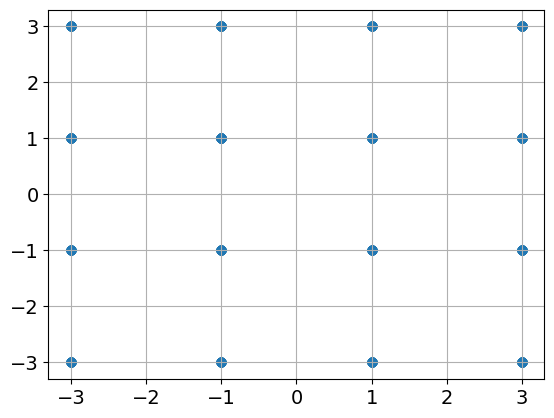

In [29]:
fig, ax = plt.subplots(1, 1)

ax.scatter(info_I, info_Q)

plt.show()

In [30]:
# info_I_up = upsample(info_I, N);      % Superamostragem para a formatação 4-PAM
# info_Q_up = upsample(info_Q, N);      % Superamostragem para a formatação 4-PAM

# s_4PAM_I = filter(filtro_4PAM, 1, info_I_up); % Sinal NRZ unipolar para fase
# s_4PAM_Q = filter(filtro_4PAM, 1, info_Q_up); % Sinal NRZ unipolar para quadratura

I_up = np.repeat(info_I, N)
Q_up = np.repeat(info_Q, N)

filtro_4PAM = np.ones(N)

s_4PAM_I = sp.signal.lfilter(filtro_4PAM, 1, I_up)
S_4PAM_I = fftshift(fft(s_4PAM_I))

s_4PAM_Q = sp.signal.lfilter(filtro_4PAM, 1, Q_up)
S_4PAM_Q = fftshift(fft(s_4PAM_Q))

s_t = I_up * cos(wct) - Q_up * sin(wct)
S_f = fftshift(fft(s_t))

IndexError: index 2 is out of bounds for axis 1 with size 2

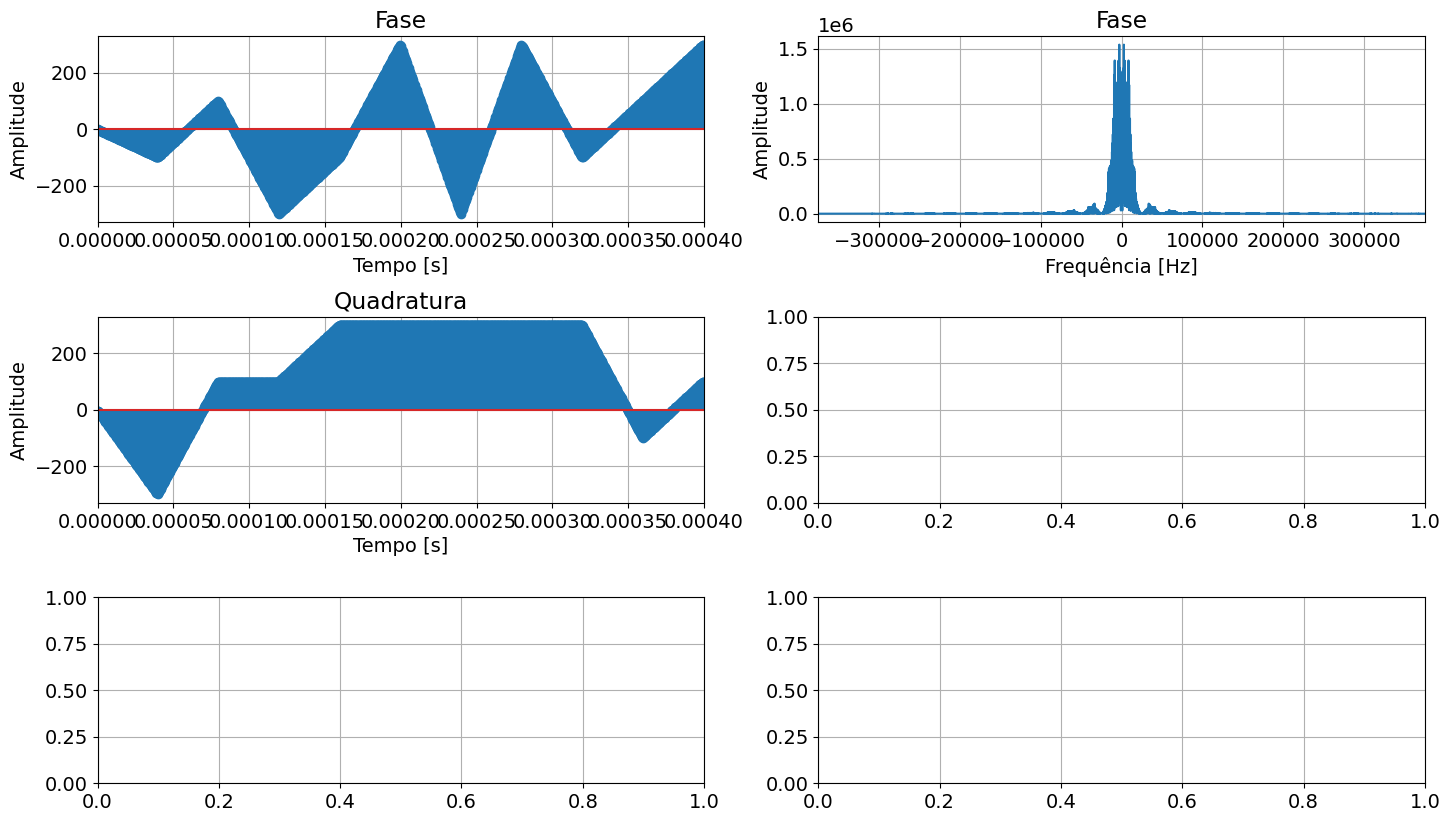

In [34]:
fig, ax = plt.subplots(3, 2, figsize=(15, 9))
fig.tight_layout(pad=3)

ax[0, 0].stem(t, s_4PAM_I)
ax[0, 0].set_title("Fase")
ax[0, 0].set_xlabel("Tempo [s]")
ax[0, 0].set_ylabel("Amplitude")
ax[0, 0].set_xlim(0, 10 * Ts)

ax[0, 1].plot(f, np.abs(S_4PAM_I))
ax[0, 1].set_title("Fase")
ax[0, 1].set_xlabel("Frequência [Hz]")
ax[0, 1].set_ylabel("Amplitude")
ax[0, 1].set_xlim(-3 * fc, 3 * fc)

ax[1, 0].stem(t, s_4PAM_Q)
ax[1, 0].set_title("Quadratura")
ax[1, 0].set_xlabel("Tempo [s]")
ax[1, 0].set_ylabel("Amplitude")
ax[1, 0].set_xlim(0, 10 * Ts)

ax[0, 2].plot(f, np.abs(S_4PAM_Q))
ax[0, 2].set_title("Fase")
ax[0, 2].set_xlabel("Frequência [Hz]")
ax[0, 2].set_ylabel("Amplitude")
ax[0, 2].set_xlim(-3 * fc, 3 * fc)

ax[2, 0].plot(t, s_t)
ax[2, 0].set_title("Sinal transmitido")
ax[2, 0].set_xlabel("Tempo [s]")
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].set_xlim(0, 10 * Ts)

ax[0, 3].plot(f, np.abs(S_f))
ax[0, 3].set_title("Fase")
ax[0, 3].set_xlabel("Frequência [Hz]")
ax[0, 3].set_ylabel("Amplitude")
ax[0, 3].set_xlim(-3 * fc, 3 * fc)

plt.show()

# Recepção

In [32]:
ordem = 100
f_cut = 1.1 * Rs

In [33]:
I_r_t = s_t * cos(wct)
Q_r_t = s_t * -sin(wct)

filtro_pb = sp.signal.firwin(ordem, f_cut / (Fa / 2))

r_t_I_filtrado = sp.signal.lfilter(filtro_pb, 1, I_r_t)
r_t_Q_filtrado = sp.signal.lfilter(filtro_pb, 1, Q_r_t)